# Transfer Learning using Keras

In [1]:
# Model (functional API) https://keras.io/models/model/
# https://keras.io/getting-started/functional-api-guide/
from keras.models import Model

# Stochastic Gradient Descent Optimizer https://keras.io/optimizers/
from keras.optimizers import SGD

# Xception V1 model, with weights pre-trained on ImageNet
# https://keras.io/applications/#xception
from keras.applications import Xception # TensorFlow ONLY    

# Generating input variations
# https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator   

# These are some of the building blocks of NNs
from keras.layers import Flatten, Dense, Dropout

Using TensorFlow backend.


In [2]:
import numpy as np
from scipy import ndimage, misc

# Plotting images and graphics in the notebook
import matplotlib.pyplot as plt
% matplotlib inline

## Training

### Model

In [3]:
# We define the shape of the images processed by the neural network
# the minimum accepted by Xception is 299x299x3
shape_x, shape_y, depth = (299, 299, 3)

# include_top=False 
model = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(shape_x, shape_y, depth))

# all the layers from Xception are fixed, not trainable
for layer in model.layers:
    layer.trainable = False

# we take the last layer of the model and connect it to new layers
output = model.get_layer(index=-1).output
output = Flatten(name='flatten')(output)
output = Dropout(0.2)(output)
output = Dense(2, activation='softmax', name='predictions')(output)

# the non trainable layers and the new layers are fused together into a model
transfer_model = Model(model.input, output)

# adding the sgd optimizer with low learning rate, momentum(=inertia) and decay (no decay)
optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=True)

# model is compiled and ready to be used 
# the cost function is crossentropy (sum of negative log of the probability of the correct class)
# but we report the more intuitive accuracy
transfer_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Data generators

In [4]:
training_images   = './input/train'
validation_images = './input/validation'

In [5]:
data_generator_train = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1, 
        zoom_range=0.1,
        rotation_range=15.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

data_generator_validation = ImageDataGenerator(rescale=1./255)

In [6]:
example = 4
type = "cat"
filepath = training_images+'/'+type+'s/'+type+'.'+str(example)+".jpg"
image = ndimage.imread(filepath, mode="RGB")
image_reshaped = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
i = 0
for batch in data_generator_train.flow(image_reshaped, batch_size=1, save_to_dir='./input/preview', save_prefix='gen', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

### Training phase

In [7]:
batch_size = 16

In [8]:
train_generator = data_generator_train.flow_from_directory(
        training_images,
        target_size=(shape_x, shape_y),
        batch_size=batch_size,
        shuffle=True,
        classes=['dogs', 'cats'],
        class_mode='categorical')

Found 20000 images belonging to 2 classes.


In [9]:
validation_generator = data_generator_validation.flow_from_directory(
        validation_images,
        target_size=(shape_x, shape_y),
        batch_size=batch_size,
        shuffle=True,
        classes=['dogs', 'cats'],
        class_mode='categorical')

Found 5000 images belonging to 2 classes.


In [10]:
nb_train_samples = train_generator.n
nb_validation_samples = validation_generator.n
shortcut = 10

In [11]:
print ("Training on %i examples" % (nb_train_samples // shortcut))

Training on 2000 examples


In [12]:
transfer_model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size // shortcut,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size // shortcut
        )

Epoch 1/1
125/125 [==============================] - 172s - loss: 0.4528 - acc: 0.9320 - val_loss: 0.0971 - val_acc: 0.9839

We now take some time and figure out the validation accuracy on a large number of validation images

## Testing

In [13]:
test_images = './input/test'
special_images = './input/special'

In [14]:
def guess(filepath):
    """
    loading an image, reshaping it, 
    and classifying it into the dog or cat category 
    """
    image = ndimage.imread(filepath, mode="RGB")
    # Reshaping using global width and height used for training
    # Image values is normalized between 0 and 1
    image_resized = misc.imresize(image, (shape_x, shape_y)) / 255.
    image_resized = image_resized.reshape((1,shape_x, shape_y, depth))
    dog, cat = transfer_model.predict(image_resized).tolist()[0]
    return image, dog, cat   

### Single predictions

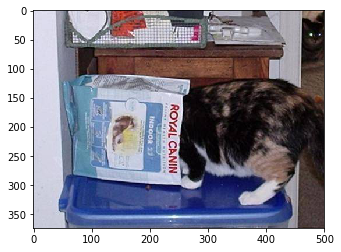

Probability being a dog: 0.0, being a cat: 100.0


In [15]:
test_example = 144
filepath = test_images+'/'+str(test_example)+".jpg"
image, dog, cat = guess(filepath)
plt.imshow(image)
plt.show()
print ("Probability being a dog: %0.1f, being a cat: %0.1f" % (dog*100, cat*100))

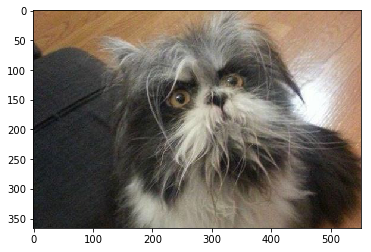

Probability being a dog: 56.0, being a cat: 44.0


In [16]:
special_example = 3
filepath = special_images + '/'+str(special_example)+".jpg"
image, dog, cat = guess(filepath)
plt.imshow(image)
plt.show()
print ("Probability being a dog: %0.1f, being a cat: %0.1f" % (dog*100, cat*100))

## Answers to special examples

special example 1: https://it.wikipedia.org/wiki/Grumpy_Cat

special example 2: https://www.theatlantic.com/technology/archive/2013/12/incredible-true-story-doge/356611/

special example 3: http://mysocialpet.it/news/curiosita/e-un-cane-o-un-gatto

## Complexity

In [17]:
transfer_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________